# Calculation of population genetic signatures of selection using quantitative metrics (Fay and Wu's H, non-monotonicity D) and comparison against detection limit (related to Figure 2 and Figure S4)

In [263]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

import bct

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73"]

# Load data

In [264]:
# Lineage dynamics data
df_expanded = pd.read_csv("data/df_expanded.filtered.csv", index_col=0)
df_persistent = pd.read_csv("data/df_persistent.filtered.csv", index_col=0)

print "Lineages"
print "Expanded", df_expanded.shape[0]
print "Persistent", df_persistent.shape[0]

# Sequences
df_seqs = pd.read_csv("data/df_seqs.filtered_V6_Full.csv", index_col=0)

print "Sequences", df_seqs.shape[0]

# Mutation frequencies
# freqs = pickle.load(open(output_dir+"/data/freqs.pickle"))

Lineages
Expanded 87
Persistent 192
Sequences 269906


# Calculate Fay and Wu's H

# Tally mutation counts (not frequencies) for each mutation

In [265]:
derived_mut_counts, derived_mut_counts_lineageSizes = bct.get_muts_counts_all(df_seqs) # takes ~160 sec

Wall clock time 9.02207493782



In [266]:
germline_muts = bct.load_germline_muts("data/")
lineage_to_alleles = bct.make_lineage_to_alleles(df_seqs)
derived_mut_counts = bct.drop_germline_muts(derived_mut_counts, germline_muts, lineage_to_alleles)

Dropped germline mutations 151


# Calculate Fay and Wu's H based on counts

In [267]:
def calc_H(mut_counts, n):
    counts = pd.Series(mut_counts).value_counts()
    theta_H = sum(2 * np.array(counts.index)**2 * counts) / (n * (n-1))
    theta_pi = sum(2 * counts * np.array(counts.index) * (n - counts.index)) / (n * (n-1))
    H = theta_pi - theta_H
    return H

In [268]:
# test on a couple lineages
print calc_H(derived_mut_counts[df_expanded.index[0]].values(), derived_mut_counts_lineageSizes[df_expanded.index[0]])
print calc_H(derived_mut_counts[df_persistent.index[0]].values(), derived_mut_counts_lineageSizes[df_persistent.index[0]])

-14.4997474597
35.1719545745


In [269]:
H_expanded = [calc_H(derived_mut_counts[x], derived_mut_counts_lineageSizes[x]) for x in df_expanded.index]
H_persistent = [calc_H(derived_mut_counts[x], derived_mut_counts_lineageSizes[x]) for x in df_persistent.index]

# Plot distributions of Fay and Wu's H

MannwhitneyuResult(statistic=4491.0, pvalue=3.1318013788319136e-10)

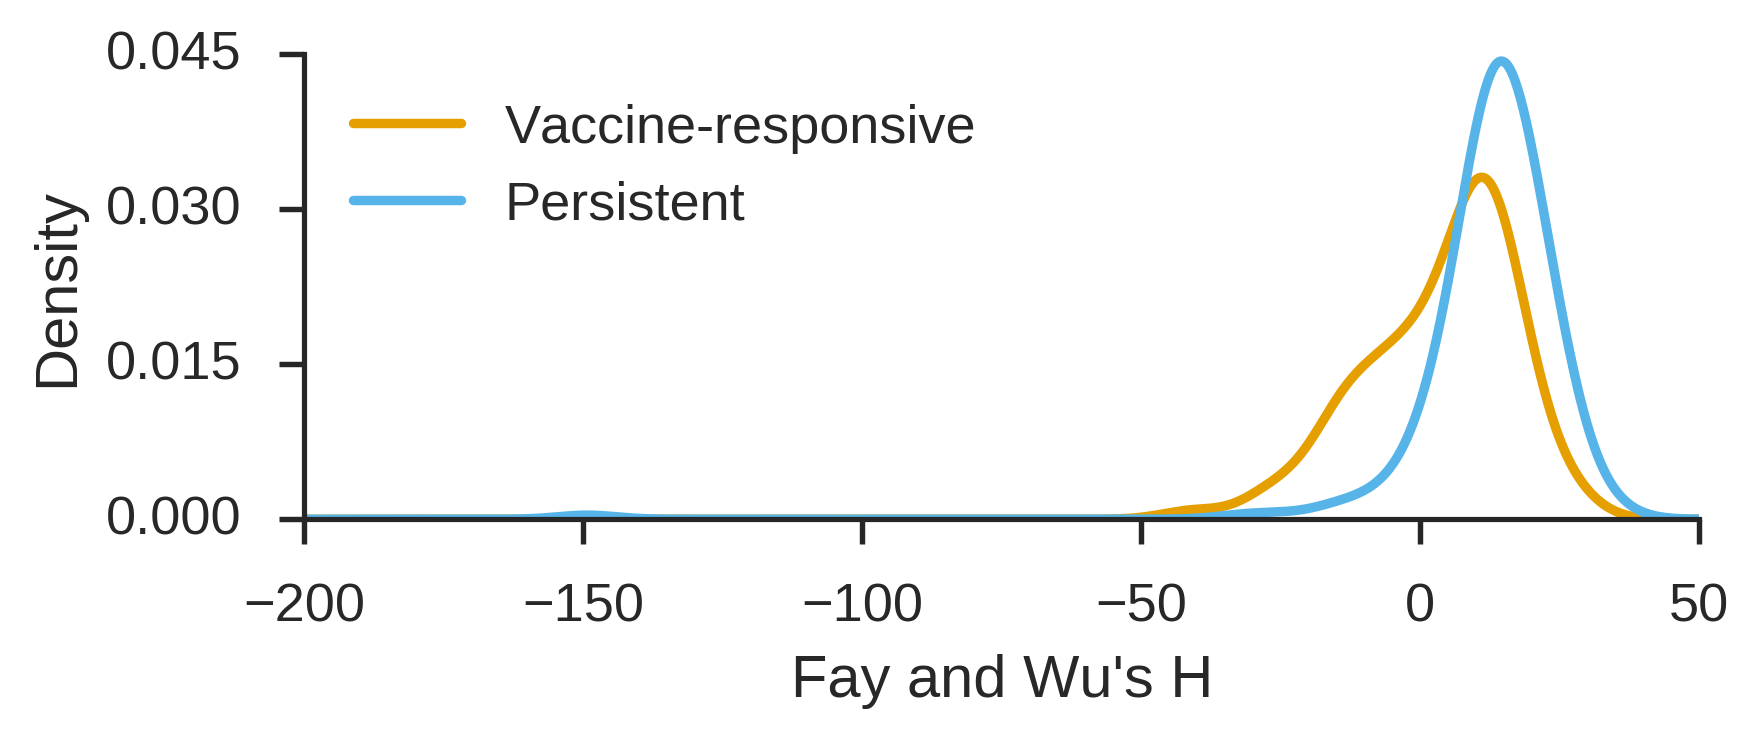

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(6,2))
xs = np.linspace(-200,50,1000)
density = scipy.stats.gaussian_kde(H_expanded)
ax.plot(xs, density(xs), c=myColors[0], label="Vaccine-responsive")
density = scipy.stats.gaussian_kde(H_persistent)
ax.plot(xs, density(xs), c=myColors[1], label="Persistent")
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4))
ax.set_xlabel("Fay and Wu's H")
ax.set_ylabel("Density")
ax.legend(loc="upper left")
sns.despine()
save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_Distributions", output_dir, output_suffix, output_formats, savefig_args)
print

scipy.stats.mannwhitneyu(H_expanded, H_persistent)

# Calculate significance by comparison with size-matched simulations

In [271]:
# Load fit parameters for size-matched ensembles
fit_params_H_kingman = pickle.load(open("data/SFS_CalculateMetrics_FayAndWusH_FitParams_kingman.pickle", 'r'))
fit_params_H_BSC = pickle.load(open("data/SFS_CalculateMetrics_FayAndWusH_FitParams_BSC.pickle", 'r'))

In [272]:
# Define functions to compare with size-matched simulations

def find_nearest(L,value):
    array = np.array(L)
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def calc_pvalue_matchedSimulations(H_focal, N_focal, params, model=scipy.stats.johnsonsu):
    
    # Find nearest N in ensemble
    N = find_nearest(params.keys(), N_focal)
    
    # Calculate p of H under nearest N
    myParams = params[N]
    p_low = model.cdf(H_focal, myParams[0], myParams[1], myParams[2], myParams[3]) # unpacking of params may need to be adjusted for different models
    p = p_low
    
    return p

In [273]:
# Example as test case

i = 0
lineage_uid = df_expanded.index[i]
H_focal = H_expanded[i]
N_focal = derived_mut_counts_lineageSizes[lineage_uid]

pvalue = calc_pvalue_matchedSimulations(H_focal, N_focal, fit_params_H_kingman)

print lineage_uid, N_focal, H_focal, pvalue

70201010000000001 9166 -14.4997474597 0.000570572330606


In [274]:
# Reformat data as df
lineage_uids = list(df_expanded.index) + list(df_persistent.index)
df_metrics = pd.DataFrame({"lineage_uid": lineage_uids})
df_metrics.set_index("lineage_uid", inplace=True)
df_metrics["label_dynamics"] = ["Vaccine-responsive"]*len(df_expanded) + ["Persistent"]*len(df_persistent)
df_metrics["num_seq"] = [derived_mut_counts_lineageSizes[x] for x in df_metrics.index]
df_metrics["H"] = [calc_H(derived_mut_counts[x], df_metrics["num_seq"].loc[x]) for x in df_metrics.index]

In [275]:
# Calculate pvalues for all lineages
df_metrics["H_pvalue_kingman"] = [calc_pvalue_matchedSimulations(row["H"], row["num_seq"], fit_params_H_kingman)
                                  for uid, row in df_metrics.iterrows()]

In [276]:
# Subset for convenience
df_metrics_expanded = df_metrics.loc[df_metrics["label_dynamics"] == "Vaccine-responsive"]
df_metrics_persistent = df_metrics.loc[df_metrics["label_dynamics"] == "Persistent"]

# Plot Fay and Wu's H

In [277]:
# Report statistics of selection
print "How many lineages are selected?"
print df_metrics.loc[df_metrics["H_pvalue_kingman"] < 0.05].shape[0]
print
print "Fraction of vaccine-responsive lineages selected"
print np.mean(df_metrics_expanded["H_pvalue_kingman"] < 0.05)
print
print "Fraction of persistent lineages selected"
print np.mean(df_metrics_persistent["H_pvalue_kingman"] < 0.05)

How many lineages are selected?
38

Fraction of vaccine-responsive lineages selected
0.310344827586

Fraction of persistent lineages selected
0.0572916666667


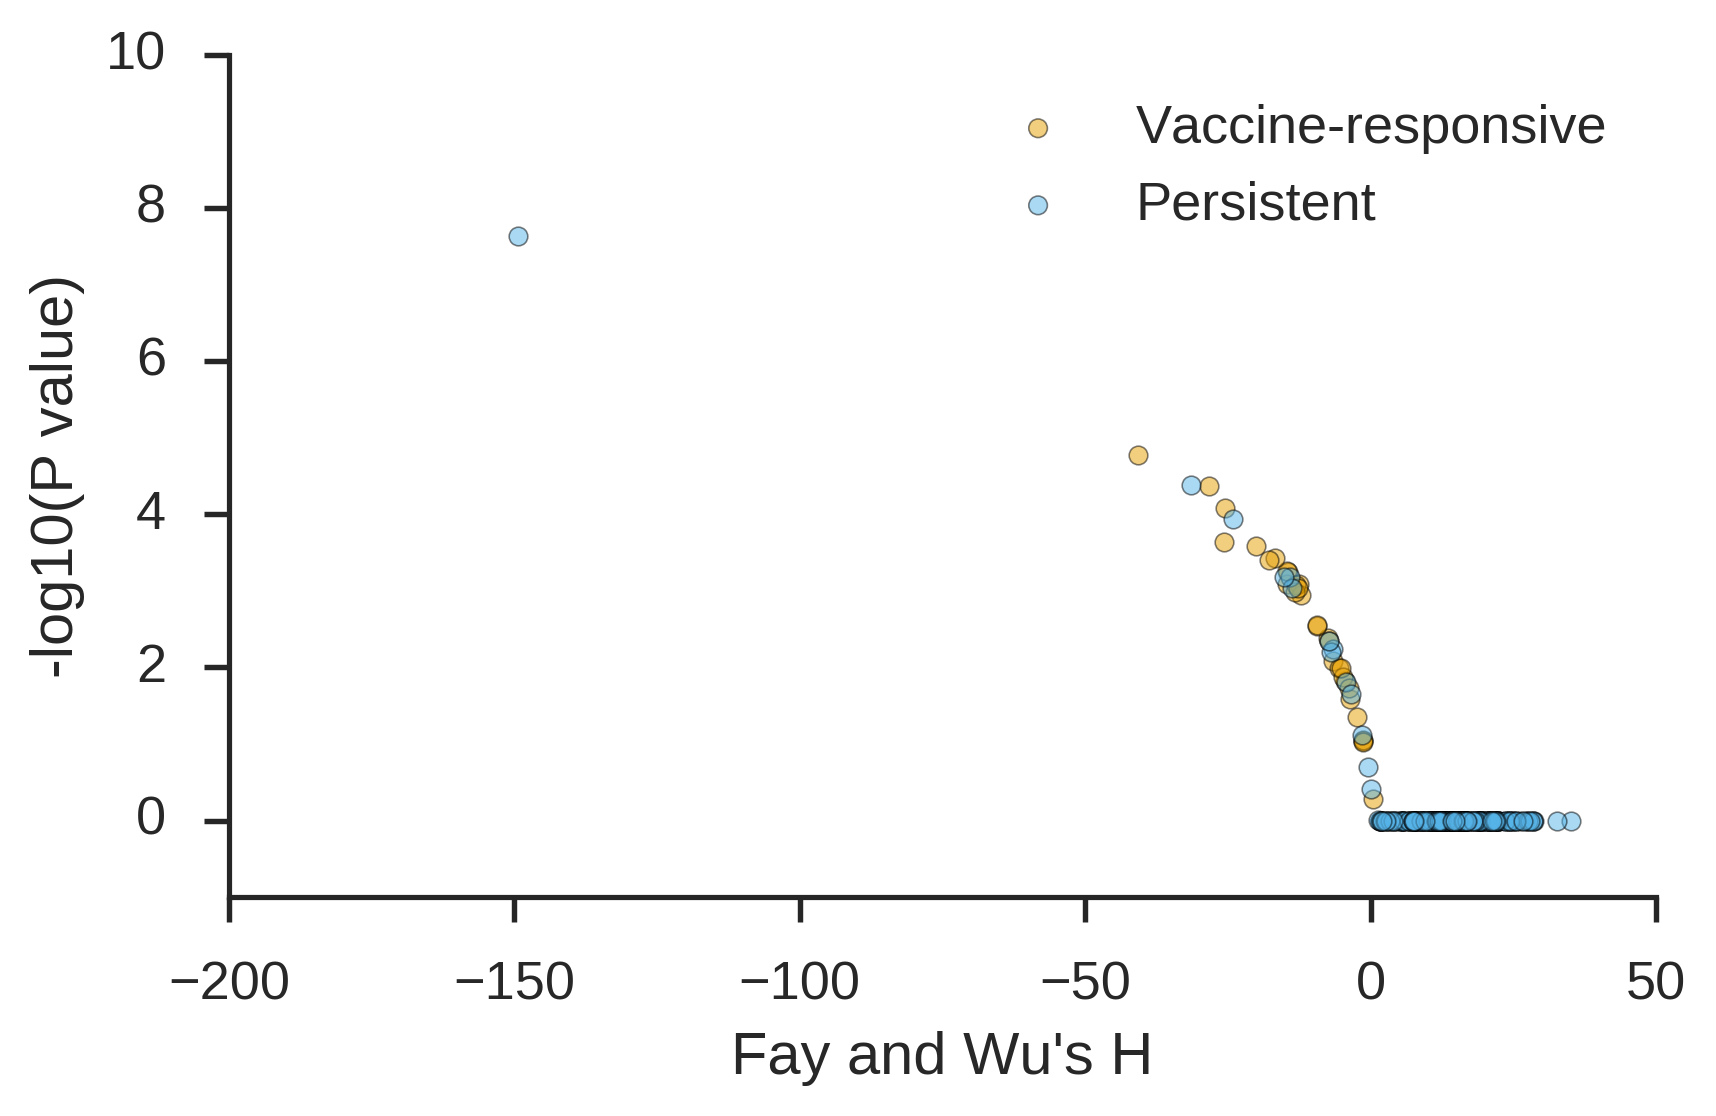

In [278]:
# Plot P value versus H as a sanity check
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(df_metrics_expanded["H"], -np.log10(df_metrics_expanded["H_pvalue_kingman"]),
           c=myColors[0], alpha=0.5, label="Vaccine-responsive")
ax.scatter(df_metrics_persistent["H"], -np.log10(df_metrics_persistent["H_pvalue_kingman"]),
           c=myColors[1], alpha=0.5, label="Persistent")
ax.set_ylim(top=10)
ax.set_xlabel("Fay and Wu's H")
ax.set_ylabel("-log10(P value)")
ax.legend(loc="upper right")
sns.despine()
plt.tight_layout()

# Plot distribution of P values with comparison with simulations

In [279]:
# Functions for generating P value distributions by sampling

def sample_from_size_matched_distributions(sizes, fit_params_generator, fit_params_null, num_reps):
    X = []
    model = scipy.stats.johnsonsu
    for i in xrange(num_reps):
        N = np.random.choice(sizes)
        nearest_N = find_nearest(fit_params_generator.keys(), N)
        my_fit_params = fit_params_generator[nearest_N]
        x = model.rvs(a=my_fit_params[0],
                      b=my_fit_params[1], 
                      loc=my_fit_params[2],
                      scale=my_fit_params[3],
                      size=1)[0]
        my_fit_params_null = fit_params_null[nearest_N]
        p = model.cdf(x,
                      my_fit_params_null[0],
                      my_fit_params_null[1],
                      my_fit_params_null[2],
                      my_fit_params_null[3])
        X.append(p)
    return np.array(X)

In [280]:
# Sample for VR
label = "Vaccine-responsive"
lineage_sizes = df_metrics_expanded["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_kingman_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_kingman,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_BSC_expanded_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_kingman,
                                                                           10000)

87 lineages


MannwhitneyuResult(statistic=287520.0, pvalue=2.4720506153948709e-08)
MannwhitneyuResult(statistic=300457.0, pvalue=3.2633722052809838e-07)
MannwhitneyuResult(statistic=36958583.0, pvalue=3.2708088597703146e-224)


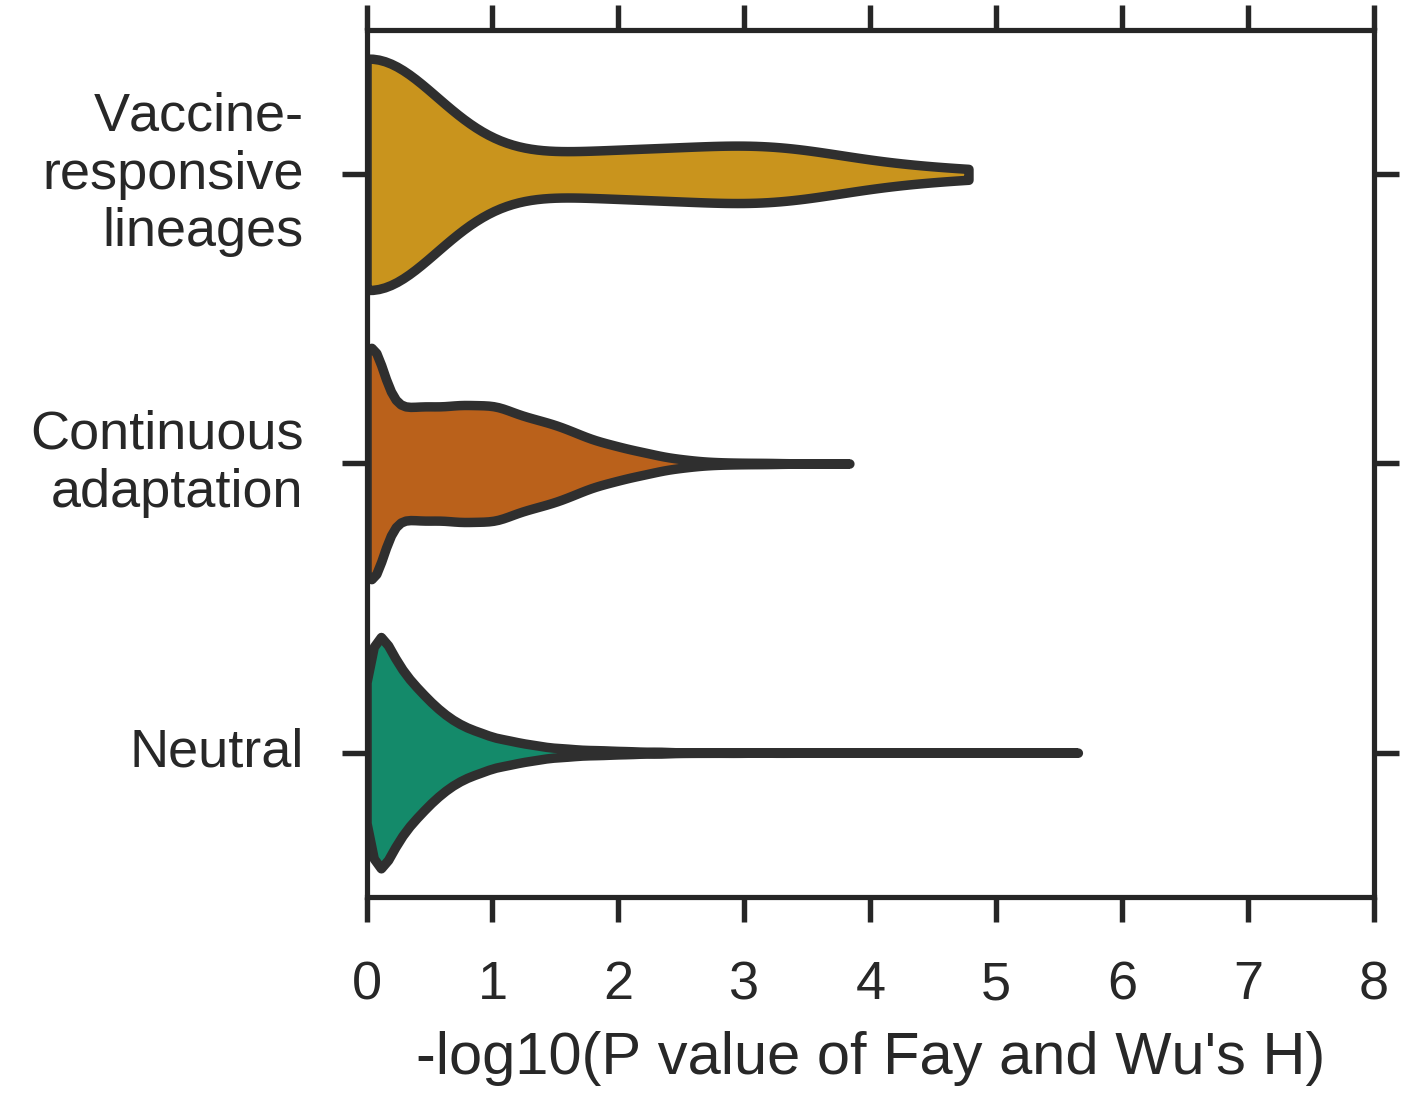

In [281]:
# Plot
data_obs = df_metrics_expanded["H_pvalue_kingman"]
data = [data_obs, pvalue_H_BSC_expanded_sizeMatched, pvalue_H_kingman_expanded_sizeMatched]

data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[0], myColors[2], myColors[3]])
ax.set_xlim(0,8)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Vaccine-\nresponsive\nlineages", "Continuous\nadaptation", "Neutral"])
plt.tight_layout()
save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulations_expanded", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

In [282]:
# Sample for P
label = "Persistent"
lineage_sizes = df_metrics_persistent["num_seq"]
print lineage_sizes.shape[0], "lineages"

pvalue_H_kingman_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                               fit_params_H_kingman,
                                                                               fit_params_H_kingman,
                                                                               10000)

pvalue_H_BSC_persistent_sizeMatched = sample_from_size_matched_distributions(lineage_sizes,
                                                                           fit_params_H_BSC,
                                                                           fit_params_H_kingman,
                                                                           10000)

192 lineages


MannwhitneyuResult(statistic=128049.0, pvalue=1.3465674773144371e-94)
MannwhitneyuResult(statistic=133148.0, pvalue=1.8116575443462597e-93)
MannwhitneyuResult(statistic=38848649.0, pvalue=1.4291266588826928e-164)


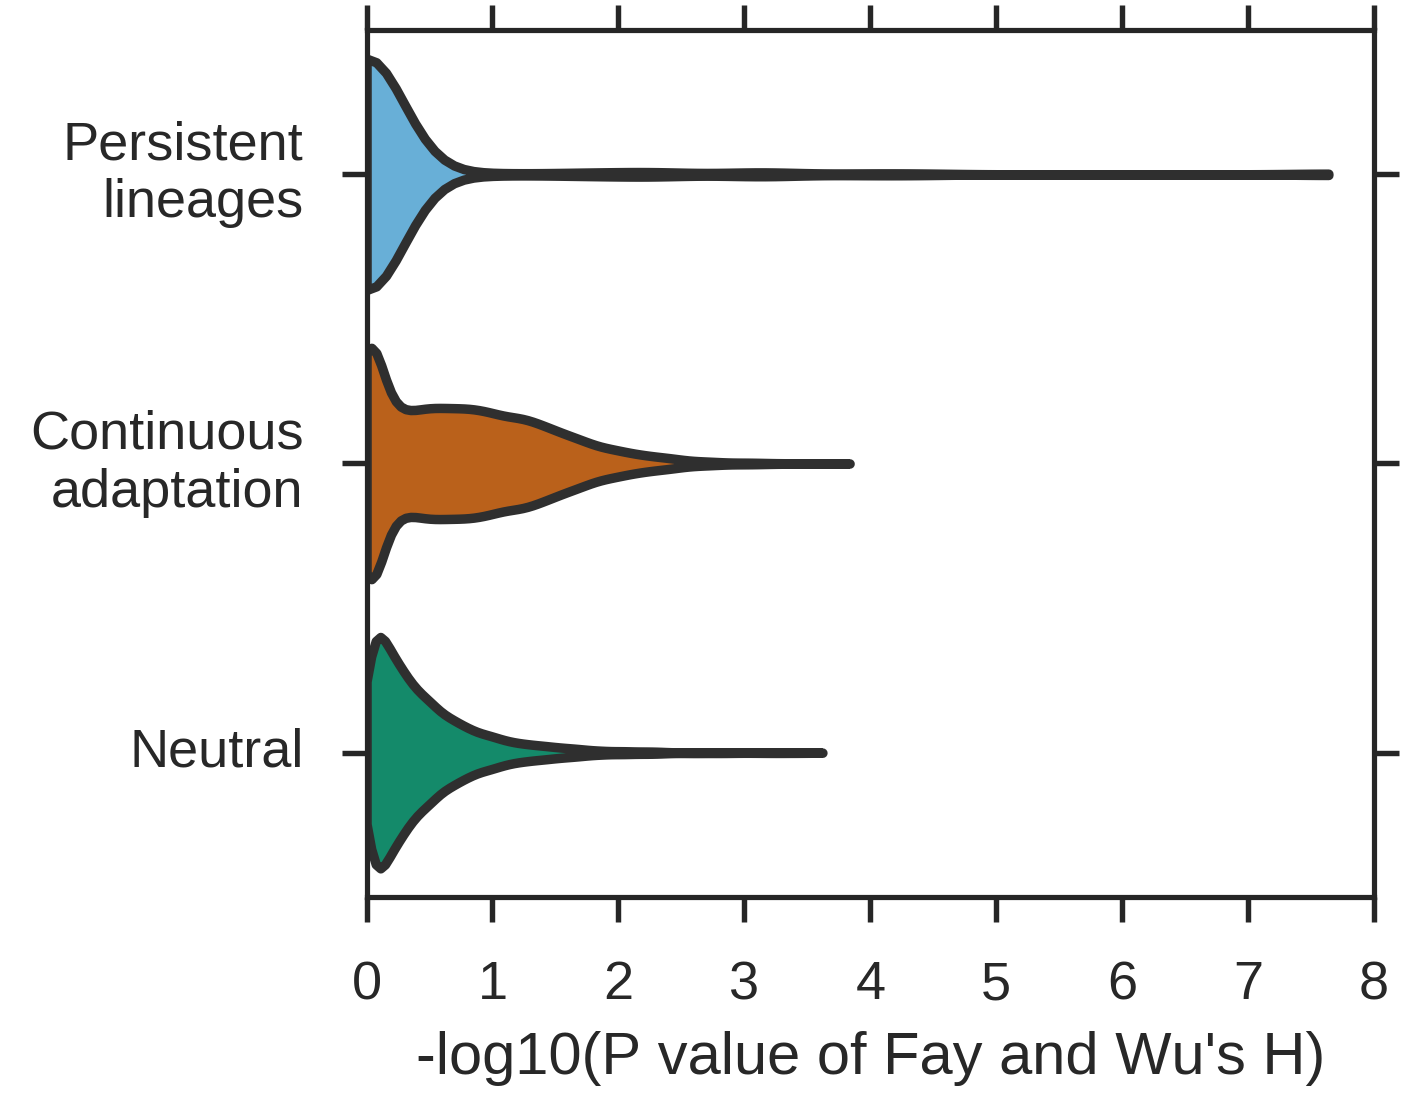

In [283]:
data_obs = df_metrics_persistent["H_pvalue_kingman"]
data = [data_obs, pvalue_H_BSC_persistent_sizeMatched, pvalue_H_kingman_persistent_sizeMatched]
data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[1], myColors[2], myColors[3]])
ax.set_xlim(0,8)
ax.set_xlabel("-log10(P value of Fay and Wu's H)")
ax.set_yticklabels(["Persistent\nlineages", "Continuous\nadaptation", "Neutral"])
plt.tight_layout()
save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_ViolinsSimulations_persistent", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])
print scipy.stats.mannwhitneyu(data[0], data[2])
print scipy.stats.mannwhitneyu(data[1], data[2])

# Calculate non-monotonicity D

# Calculate frequency of each somatic mutation

In [284]:
# Get frequencies of somatic mutations
freqs_with_germline_muts = bct.get_muts_freqs_all(df_seqs) # takes ~10 sec

# Get number of leaves in each tree
lineage_sizes = bct.get_lineage_size_all(df_seqs)

Wall clock time 9.08806109428



In [285]:
# Drop germline mutations
germline_muts = bct.load_germline_muts("data/")
lineage_to_alleles = bct.make_lineage_to_alleles(df_seqs)
freqs = bct.drop_germline_muts(freqs_with_germline_muts, germline_muts, lineage_to_alleles)

Dropped germline mutations 151


In [286]:
# Choose bins for SFS
bins = np.array([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999])
bin_centers_manual = np.array([5e-5, 5e-4, 5e-3, 5e-2, 0.25, 0.75, 1-5e-2, 1-5e-3, 1-5e-4, 1-5e-5])
bin_centers = np.sqrt(bins[1:] * bins[:-1])

# Define functions for fitting curve to high frequency region of spectrum

In [287]:
def drop_nan_inf(X, Y):
    """ Drops data points where x or y == np.nan """
    x_dropped = []
    y_dropped = []
    for x, y in zip(X, Y):
        if not np.isnan(x) and not np.isnan(y) and np.isfinite(x) and np.isfinite(y):
            x_dropped.append(x)
            y_dropped.append(y)
    return x_dropped, y_dropped

def logit(x):
    return np.log10(x) - np.log10(1-x)

def polyfit_deriv(bin_centers, binned_sfs_normed, deg, f_cutoff=0.25, plot=False):
    x = logit(bin_centers) # logit transform x
    y = np.log10(binned_sfs_normed) # log transform y
    x_clean, y_clean = drop_nan_inf(x, y) # drop values where x or y == np.nan
    coeffs = np.polyfit(x_clean, y_clean, deg=deg) # fit polynomial to SFS
    der1 = np.polyder(coeffs, m=1) # calculate first derivative
    x_fitted = np.linspace(min(x_clean), max(x_clean), 100) # dense grid of values in range of x
    y_fitted = np.polyval(coeffs, x_fitted) # evaluate polynomial fit on grid
    y_der1 = np.polyval(der1, x_fitted) # evaluate first derivative on grid
    selector = x_fitted > logit(f_cutoff) # indexes of frequency bins above cutoff
    if sum(selector) == 0: # no frequency bins above cutoff
        max_y_der1 = -np.inf
    else:
        max_y_der1 = max(y_der1[selector]) # maximum value of first derivative within range of SFS and above frequency cutoff
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
        ax.scatter(x,y, label="Data")
        ax.plot(x_fitted, y_fitted, label="Fit")
        ax.plot(x_fitted, y_der1, label="1st Derivative")
        # plt.plot(x_clean,y_der2)
        ax.set_xlabel("Mutation Frequency (logit)")
        ax.set_ylabel("Density of mutations (log10)")
        ax.legend(loc="upper right")
        sns.despine()
        plt.tight_layout()
    return max_y_der1

def max_insta_slope(bin_centers, binned_sfs_normed, f_cutoff=0.25, plot=False):
    x = logit(bin_centers) # logit transform x
    y = np.log10(binned_sfs_normed) # log transform y
    x_clean, y_clean = drop_nan_inf(x, y) # drop values where x or y == np.nan
    x_clean = np.array(x_clean)
    y_clean = np.array(y_clean)
    x_diff = x_clean[1:] - x_clean[:-1] # calculate instantaneous slope between points
    y_diff = y_clean[1:] - y_clean[:-1]
    slope = y_diff / x_diff
    x_clean_centers = (x_clean[1:] + x_clean[:-1]) / 2
    selector = x_clean[:-1] > logit(f_cutoff)
    if sum(selector) == 0: # no frequency bins above cutoff
        m = -np.inf
    else:
        m = max(slope[selector]) # maximum value of slope within range of SFS and above frequency cutoff
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
        ax.scatter(x,y, label="Data")
        ax.plot(x_clean, y_clean, label="Fit")
        ax.plot(x_clean_centers, slope, label="Slope")
        # plt.plot(x_clean,y_der2)
        ax.set_xlabel("Mutation Frequency (logit)")
        ax.set_ylabel("Density of mutations (log10)")
        ax.legend(loc="upper right")
        sns.despine()
        plt.tight_layout()
    return m

# Compute D for each lineage

In [290]:
def polyfit_deriv_ensemble(freqs, lineage_uids, bins, deg, f_cutoff):
    """ Calculate mean SFS over an ensemble by taking mean value at each bin """
    X = np.empty(len(lineage_uids))
    for i, lineage_uid in enumerate(lineage_uids):
        myFreqs = freqs[lineage_uid].values()
        myLeaves = lineage_sizes[lineage_uid]
        binned_sfs, binned_sfs_normed = bct.bin_sfs_cut(myFreqs, bins=bins, leaves=myLeaves)
        max_y_der1 = polyfit_deriv(bin_centers, binned_sfs_normed, deg=deg, f_cutoff=f_cutoff)
        X[i] = max_y_der1
    return X

def max_insta_slope_ensemble(freqs, lineage_uids, bins, f_cutoff):
    """ Calculate mean SFS over an ensemble by taking mean value at each bin """
    X = np.empty(len(lineage_uids))
    for i, lineage_uid in enumerate(lineage_uids):
        myFreqs = freqs[lineage_uid].values()
        myLeaves = lineage_sizes[lineage_uid]
        binned_sfs, binned_sfs_normed = bct.bin_sfs_cut(myFreqs, bins=bins, leaves=myLeaves)
        m = max_insta_slope(bin_centers, binned_sfs_normed, f_cutoff=f_cutoff)
        X[i] = m
    return X

# D_expanded = max_insta_slope_ensemble(freqs, list(df_expanded.index), bins, f_cutoff=0.5)
# D_persistent = max_insta_slope_ensemble(freqs, list(df_persistent.index), bins, f_cutoff=0.5)

D_expanded = polyfit_deriv_ensemble(freqs, list(df_expanded.index), bins, deg=2, f_cutoff=0.5)
D_persistent = polyfit_deriv_ensemble(freqs, list(df_persistent.index), bins, deg=2, f_cutoff=0.5)

/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [291]:
print "Fraction of expanded lineages with positive D"
print sum(D_expanded > 0) / float(len(D_expanded))
print "Number", sum(D_expanded > 0)
print
print "Fraction of persistent lineages with positive D"
print sum(D_persistent > 0) / float(len(D_persistent))
print "Number", sum(D_persistent > 0)

Fraction of expanded lineages with positive D
0.35632183908
Number 31

Fraction of persistent lineages with positive D
0.0729166666667
Number 14


In [292]:
# Write into dataframe
df_metrics["D"] = 0.
df_metrics["D"].loc[list(df_expanded.index)] = D_expanded
df_metrics["D"].loc[list(df_persistent.index)] = D_persistent

# Calculate significance by comparison with size-matched simulations

In [293]:
# Load fit parameters
# Fits were precalculated (takes several hours)

with open("data/monotonicityMaxFirstDeriv_fit_params_kingman.pickle", 'r') as f:
    fit_params_D_kingman = pickle.load(f)
    
with open("data/monotonicityMaxFirstDeriv_fit_params_BSC.pickle", 'r') as f:
    fit_params_D_BSC = pickle.load(f)

In [294]:
def calc_pvalue_matchedSimulations_infInflated(x, N, params, model=scipy.stats.johnsonsu):
    N_nearest = find_nearest(params.keys(), N) # Find nearest N in ensemble
    myParams = params[N_nearest] # Get fit parameters for nearest N
    if x == -np.inf: return 1.0
    fracInf = myParams[0]
    p = 1-(fracInf + (1-fracInf)*model.cdf(x, myParams[1], myParams[2], myParams[3], myParams[4])) # calculate p value of x
    return p

In [295]:
# Calculate P value of non-monotonicity of each lineage under Kingman
pvalues = []
indexes = df_metrics.index
for lineage_uid, row in df_metrics.loc[indexes].iterrows():
    p = calc_pvalue_matchedSimulations_infInflated(row["D"], row["num_seq"], params=fit_params_D_kingman)
    pvalues.append(p)
df_metrics["D_pvalue_kingman"] = 0.
df_metrics["D_pvalue_kingman"].loc[indexes] = pvalues

In [296]:
# Subset for convenience
df_metrics_expanded = df_metrics.loc[df_metrics["label_dynamics"] == "Vaccine-responsive"]
df_metrics_persistent = df_metrics.loc[df_metrics["label_dynamics"] == "Persistent"]

In [297]:
print "Fraction of expanded lineages with significantly positive D"
print np.mean(df_metrics_expanded["D_pvalue_kingman"] < 0.05)
print
print "Fraction of persistent lineages with significantly positive D"
print np.mean(df_metrics_persistent["D_pvalue_kingman"] < 0.05)

Fraction of expanded lineages with significantly positive D
0.16091954023

Fraction of persistent lineages with significantly positive D
0.0104166666667


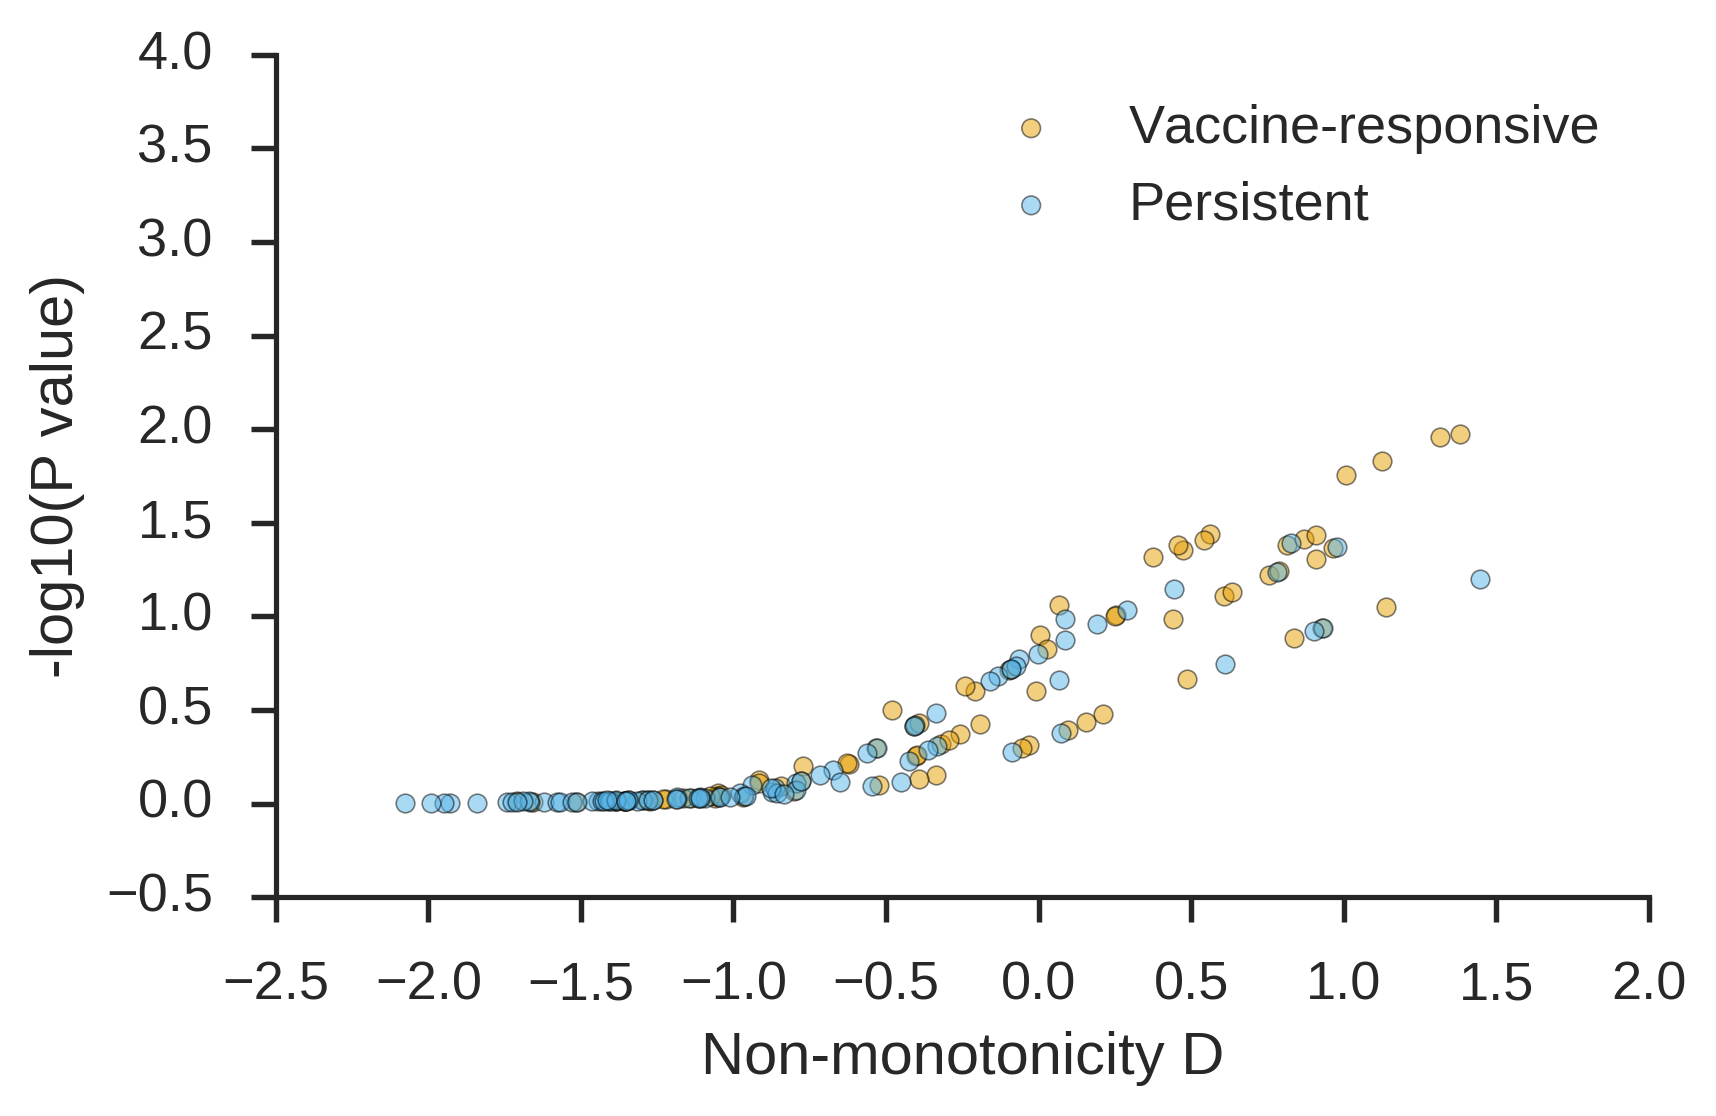

In [298]:
# Plot P value versus D as a sanity check
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(df_metrics_expanded["D"], -np.log10(df_metrics_expanded["D_pvalue_kingman"]),
           c=myColors[0], alpha=0.5, label="Vaccine-responsive")
ax.scatter(df_metrics_persistent["D"], -np.log10(df_metrics_persistent["D_pvalue_kingman"]),
           c=myColors[1], alpha=0.5, label="Persistent")
ax.set_ylim(top=4)
ax.set_xlabel("Non-monotonicity D")
ax.set_ylabel("-log10(P value)")
ax.legend(loc="upper right")
sns.despine()
plt.tight_layout()

MannwhitneyuResult(statistic=3254.0, pvalue=2.1295462842269675e-17)


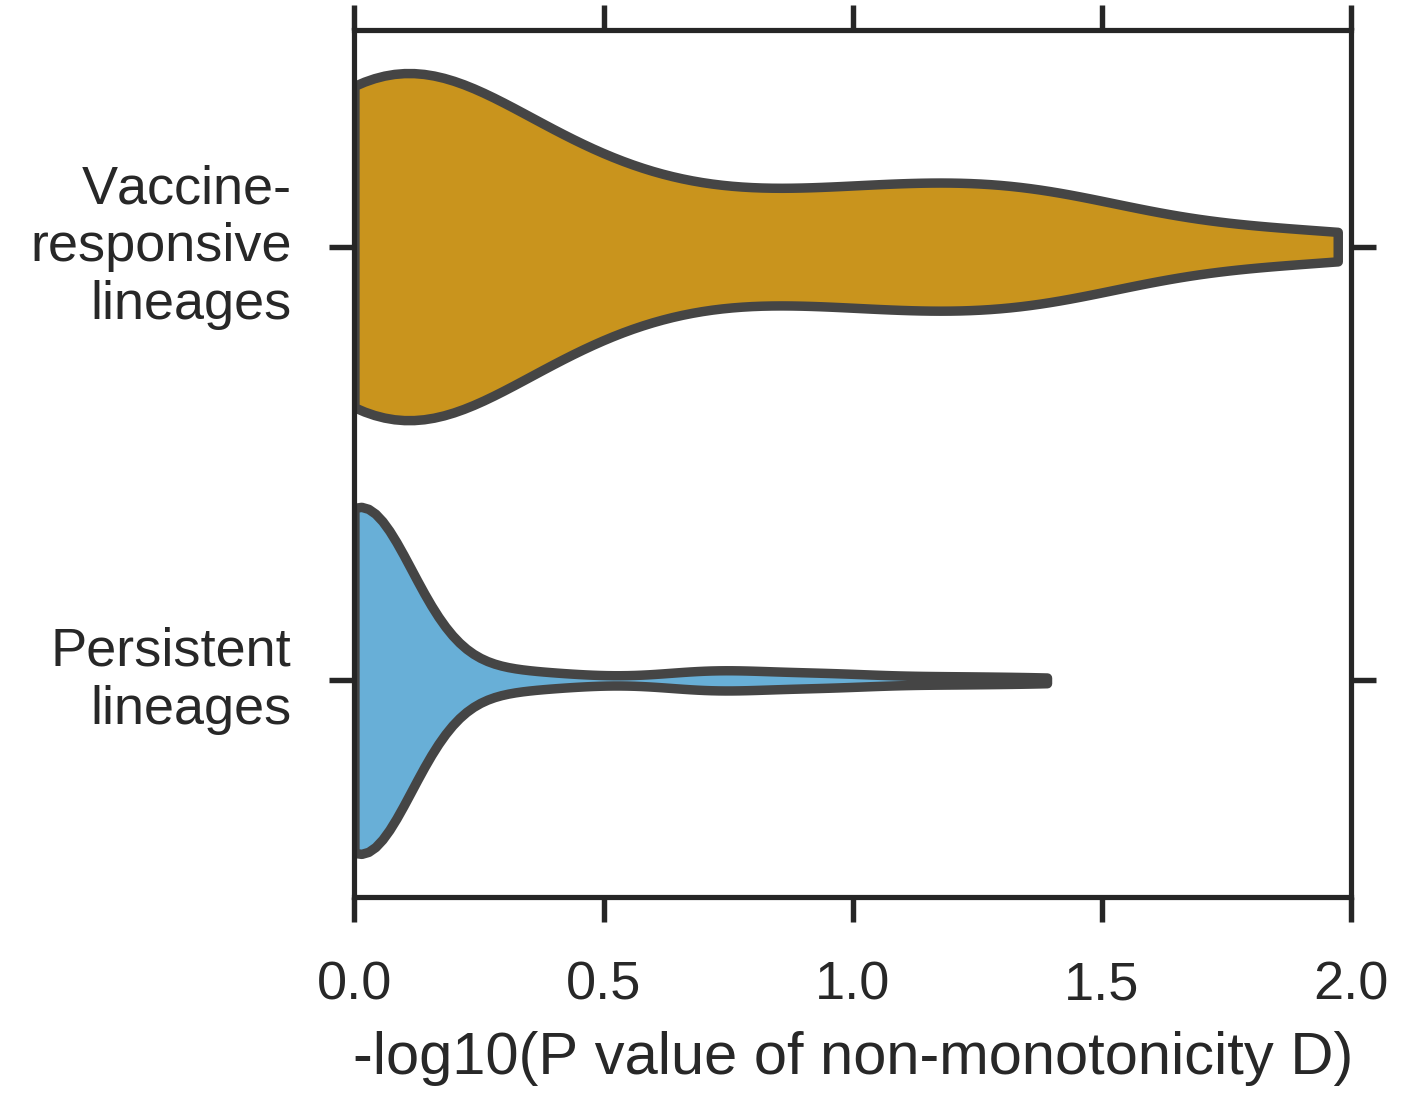

In [299]:
# Plot
data = [df_metrics_expanded["D_pvalue_kingman"], df_metrics_persistent["D_pvalue_kingman"]]
data = [-np.log10(x) for x in data]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.violinplot(ax=ax, data=data, orient="h", scale="width",
               cut=0, width=0.8, inner=None,
               palette=[myColors[0], myColors[1]])
ax.set_xlim(0,2)
ax.set_xlabel("-log10(P value of non-monotonicity D)")
ax.set_yticklabels(["Vaccine-\nresponsive\nlineages", "Persistent\nlineages"])
plt.tight_layout()
save_figure(fig, "SFS_CalculateMetrics_NonmonotonicityD_Violins", output_dir, output_suffix, output_formats, savefig_args)

# Statistics
print scipy.stats.mannwhitneyu(data[0], data[1])

# Write metrics to file

In [300]:
df_metrics.to_csv("data/df_metrics.csv")
df_metrics_expanded.to_csv("data/df_metrics_expanded.csv")
df_metrics_persistent.to_csv("data/df_metrics_persistent.csv")

# Compare with detection limit

# Calculate sensitivity and specificity for lineages of various sizes

In [301]:
# quick test to calculate sensitivity for a particular value of specificity and N

specificity = 0.05
N = 10000
model = scipy.stats.johnsonsu

# get H cutoff using kingman model and specificity
myParams = fit_params_H_kingman[N]
H_critical = model.ppf(specificity, myParams[0], myParams[1], myParams[2], myParams[3])

# get sensitivity based on H cutoff
myParams = fit_params_H_BSC[N]
sensitivity = model.cdf(H_critical, myParams[0], myParams[1], myParams[2], myParams[3])

print specificity
print H_critical
print sensitivity

0.05
-2.15619922662
0.384443244099


In [302]:
# calculate curves of sensitivity for varying N with various specificity

def calc_sensitivity(N, specificity):
    model = scipy.stats.johnsonsu
    myParams = fit_params_H_kingman[N]
    H_critical = model.ppf(specificity, myParams[0], myParams[1], myParams[2], myParams[3])
    myParams = fit_params_H_BSC[N]
    sensitivity = model.cdf(H_critical, myParams[0], myParams[1], myParams[2], myParams[3])
    return sensitivity

sensitivity = pd.DataFrame() # indexed by specificity, then N
sensitivity["N"] = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
for specificity in [0.01, 0.05, 0.1, 0.2]:
    myVals = [calc_sensitivity(N, specificity) for N in sensitivity["N"]]
    sensitivity[specificity] = myVals
sensitivity.set_index("N", inplace=True)

In [303]:
sensitivity

,0.01,0.05,0.1,0.2
N,,,,
10,0.008958,0.064308,0.130104,0.236245
20,0.019833,0.106823,0.193580,0.317507
50,0.013120,0.105760,0.211245,0.362542
100,0.025436,0.148475,0.262486,0.410107
200,0.042122,0.191246,0.311196,0.454741
500,0.055857,0.244385,0.379339,0.526569
1000,0.042281,0.261623,0.417302,0.571326
2000,0.065516,0.293005,0.439281,0.585142
5000,0.091529,0.348243,0.493358,0.629410


In [304]:
# # save sensitivity data
# sensitivity.to_csv("data/df_sensitivity.csv")

# # load sensitivity data
# sensitivity = pd.read_csv("data/df_sensitivity.csv", header=0, index_col=0)

# Plot detection of selection versus detection limit

In [305]:
# bin lineages based on number of sequences
bins = [100, 200, 500, 1000, 2000, 5000, 10000]
df_metrics["num_seq_bin"] = [find_nearest(bins, x) for x in df_metrics["num_seq"]]
df_metrics_expanded["num_seq_bin"] = [find_nearest(bins, x) for x in df_metrics_expanded["num_seq"]]
df_metrics_persistent["num_seq_bin"] = [find_nearest(bins, x) for x in df_metrics_persistent["num_seq"]]

/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


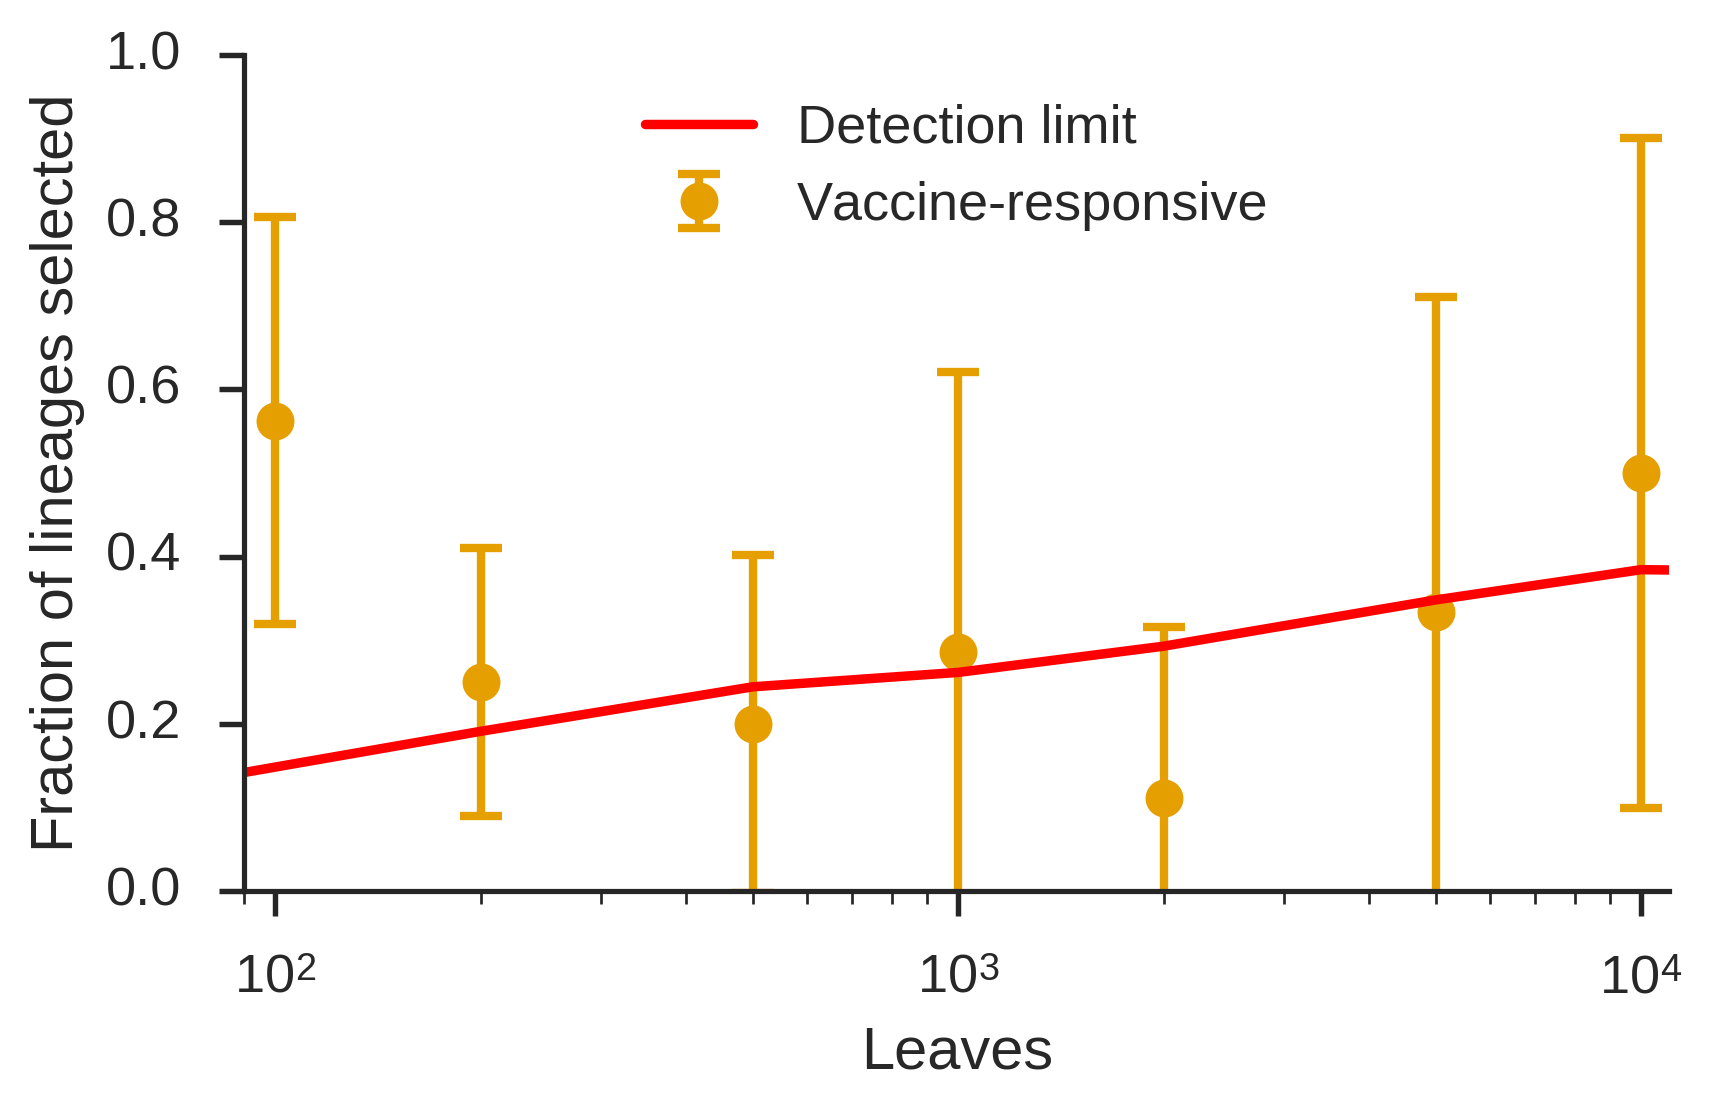

In [310]:
# Vaccine-responsive

specificity = 0.05

from statsmodels.stats import proportion

fig, ax = plt.subplots(1, 1, figsize=(6,4))

leaves_obs = []
sensitivity_obs = []
sensitivity_obs_err = []

for num_seq_bin, group in df_metrics_expanded.groupby("num_seq_bin"):
    leaves_obs.append(num_seq_bin)
    hits = sum(group["H_pvalue_kingman"] < specificity)
    n_obs = float(group.shape[0])
    hit_rate = hits/n_obs
    sensitivity_obs.append(hit_rate)
    err = proportion.proportion_confint(hits, n_obs) # calculate binomial confidence intervals (95%)
    err_size = err[1] - hit_rate
    sensitivity_obs_err.append(err_size)
    
ax.errorbar(leaves_obs, sensitivity_obs, yerr=sensitivity_obs_err, label="Vaccine-responsive",
            marker="o", linestyle="none", color=myColors[0], lw=2, capsize=5, capthick=2)

ax.plot(sensitivity.index, np.array(sensitivity[specificity]),
        color="r", label="Detection limit")

ax.set_xlim(90, 1.1e4)
ax.set_ylim(0, 1)
ax.set_xscale('log')
ax.set_ylabel("Fraction of lineages selected")
ax.set_xlabel("Leaves")
ax.legend(loc="upper center")
sns.despine()
plt.tight_layout()

save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_SelectionLimit_expanded", output_dir, output_suffix, output_formats, savefig_args)

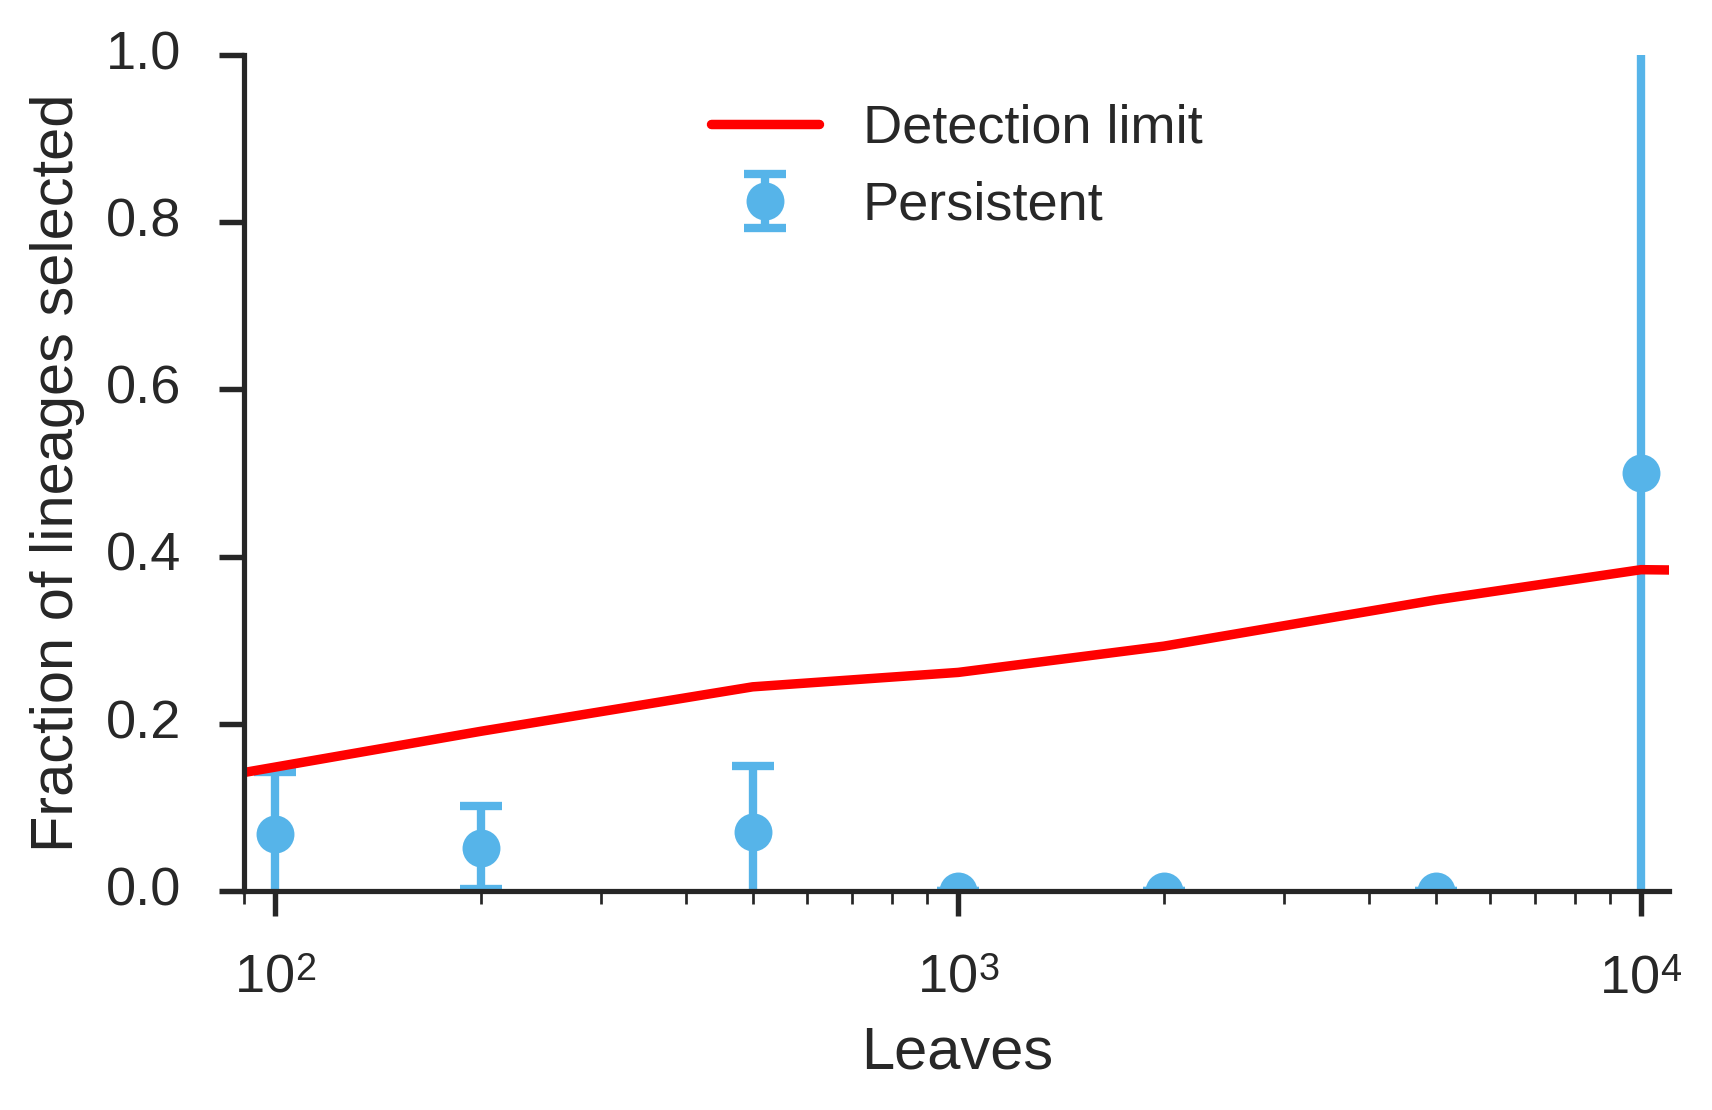

In [309]:
# Persistent

specificity = 0.05

from statsmodels.stats import proportion

fig, ax = plt.subplots(1, 1, figsize=(6,4))

leaves_obs = []
sensitivity_obs = []
sensitivity_obs_err = []

for num_seq_bin, group in df_metrics_persistent.groupby("num_seq_bin"):
    leaves_obs.append(num_seq_bin)
    hits = sum(group["H_pvalue_kingman"] < specificity)
    n_obs = float(group.shape[0])
    hit_rate = hits/n_obs
    sensitivity_obs.append(hit_rate)
    err = proportion.proportion_confint(hits, n_obs) # calculate binomial confidence intervals (95%)
    err_size = err[1] - hit_rate
    sensitivity_obs_err.append(err_size)
    
ax.errorbar(leaves_obs, sensitivity_obs, yerr=sensitivity_obs_err, label="Persistent",
            marker="o", linestyle="none", color=myColors[1], lw=2, capsize=5, capthick=2)

ax.plot(sensitivity.index, np.array(sensitivity[specificity]),
        color="r", label="Detection limit")

ax.set_xlim(90, 1.1e4)
ax.set_ylim(0, 1)
ax.set_xscale('log')
ax.set_ylabel("Fraction of lineages selected")
ax.set_xlabel("Leaves")
ax.legend(loc="upper center")
sns.despine()
plt.tight_layout()

save_figure(fig, "SFS_CalculateMetrics_FayAndWusH_SelectionLimit_persistent", output_dir, output_suffix, output_formats, savefig_args)